In [ ]:
from google.colab import drive
# mount drive to access data
drive.mount('/content/drive')
# load data folder into working directory
!cp -r drive/MyDrive/data .
!cp -r drive/MyDrive/preprocessing.py .

### Imports

In [1]:
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import preprocessing as p
from nltk.util import bigrams
from itertools import compress
import numpy as np
import math

In [2]:
# loading raw data
raw_data = pd.read_csv('data/TweetsCOV19.csv')
print(raw_data.shape)

(675375, 15)


/var/folders/n6/w16z2dmj2g9d1pd2dt_r8xl80000gn/T/ipykernel_50005/1333828246.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/TweetsCOV19.csv')


In [3]:
raw_data.head(5)

,Unnamed: 0,TweetId,Username,Timestamp,NoFollowers,NoFriends,NoRetweets,NoFavorites,Entities,Sentiment,Mentions,Hashtags,URLs,TweetText,UserLocation
0,0,1178793230223183872,bf05d1888dd974fa4a8679c25e2ead03,2019-09-30 22:06:21+00:00,5018.0,1933.0,0.0,0.0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,From my blog: Californians support vaccine law...,"Los Angeles, CA"
1,1,1178798309491822592,00695cf79d60e86a5d0f872f4358337a,2019-09-30 22:26:32+00:00,9009.0,4943.0,26.0,89.0,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,Secretary of State should recall Stormont next...,United Kingdom
2,2,1178806730358059008,6c9c28a4e449e0fe0d4d2ff449b8d6bc,2019-09-30 23:00:00+00:00,237005.0,559.0,2.0,3.0,ied:Improvised_explosive_device:-1.76224648952...,2 -3,null;,null;,https://www.fox5vegas.com/toby-keith-and-a-vet...,"While serving in Afghanistan in 2010, Marine C...",Las Vegas
3,3,1178807288171130880,000000e6bded7cdeaffee6928df45050,2019-09-30 23:02:13+00:00,1658.0,23.0,2.0,4.0,null;,1 -1,null;,null;,null;,witch vixen season starts tomorrow. you all sh...,irl
4,4,1178809851843006464,0fc683f42b4929419e796c5d0d97ce1b,2019-09-30 23:12:24+00:00,14231403.0,43.0,3.0,10.0,cgtn:China_Global_Television_Network:-1.951800...,1 -1,null;,PRC70 NationalDay2019,https://news.cgtn.com/news/2019-09-26/Live-Gra...,"CGTN on the scene: \n\nAround 15,000 troops, 3...","Beijing, China"


In [4]:
data = pd.read_csv('data/cleaned_tweets.csv')
data.shape

(563895, 15)

In [5]:
data.head(5)

,Unnamed: 0,TweetId,Username,Timestamp,NoFollowers,NoFriends,NoRetweets,NoFavorites,Entities,Sentiment,Mentions,Hashtags,URLs,TweetText,UserLocation
0,0,1.178793e+18,bf05d1888dd974fa4a8679c25e2ead03,2019-09-30 22:06:21+00:00,5018.0,1933.0,0.0,0.0,vaccine:Vaccine:-2.6651530673745762;anti vaxxe...,2 -1,null;,null;,https://goo.gl/fb/uoeiPk:-:,from my blog californian support vaccine law –...,"Los Angeles, CA"
1,1,1.178798e+18,00695cf79d60e86a5d0f872f4358337a,2019-09-30 22:26:32+00:00,9009.0,4943.0,26.0,89.0,people of northern ireland:People_of_Northern_...,2 -1,null;,VFS,null;,secretary of state should recall stormont next...,United Kingdom
2,2,1.178807e+18,6c9c28a4e449e0fe0d4d2ff449b8d6bc,2019-09-30 23:00:00+00:00,237005.0,559.0,2.0,3.0,ied:Improvised_explosive_device:-1.76224648952...,2 -3,null;,null;,https://www.fox5vegas.com/toby-keith-and-a-vet...,while serving in afghanistan in 2010 marine co...,Las Vegas
3,3,1.178807e+18,000000e6bded7cdeaffee6928df45050,2019-09-30 23:02:13+00:00,1658.0,23.0,2.0,4.0,null;,1 -1,null;,null;,null;,witch vixen season start tomorrow you all shou...,irl
4,4,1.178810e+18,0fc683f42b4929419e796c5d0d97ce1b,2019-09-30 23:12:24+00:00,14231403.0,43.0,3.0,10.0,cgtn:China_Global_Television_Network:-1.951800...,1 -1,null;,PRC70 NationalDay2019,https://news.cgtn.com/news/2019-09-26/Live-Gra...,cgtn on the scene around 15000 troop 32 equipm...,"Beijing, China"


In [6]:
# tokenize the preprocessed tweets
tweets = data['TweetText'].tolist()
tokenized_tweets = p.tokenization(tweets)

In [7]:
# returns ngrams, ordered by frequency
def ngram_freq(tweets, n):

    ngrams = dict()

    for tweet in tweets:
        for i in range(len(tweet)-n + 1):
            if tuple(tweet[i:i+n]) in ngrams:
                ngrams[tuple(tweet[i:i+n])] += 1
            else:
                ngrams[tuple(tweet[i:i+n])] = 1

    ngrams = sorted(ngrams.items(), key=lambda x:-x[1])

    return ngrams

In [10]:
# remove nans from raw_data
raw_data = raw_data[raw_data['TweetText'].notnull()]
raw_data.shape

(675370, 15)

In [11]:
# turn tweets into words
raw_tweets = raw_data['TweetText'].tolist()
for i, tweet in enumerate(raw_tweets):
  raw_tweets[i] = tweet.split()

In [13]:
# get most frequent unigrams and bigrams
unigrams = ngram_freq(tokenized_tweets, 1)
raw_unigrams = ngram_freq(raw_tweets, 1)
bigrams = ngram_freq(tokenized_tweets, 2)
raw_bigrams = ngram_freq(raw_tweets, 2)

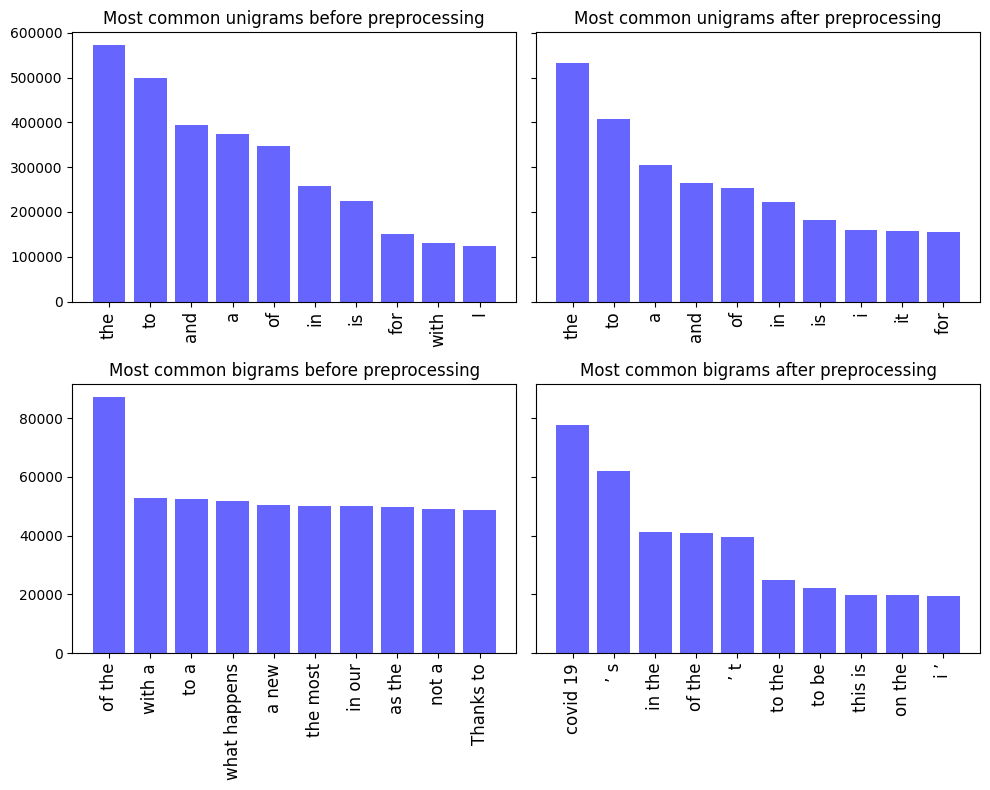

In [14]:
# plot unigram, bigram frequency before and after preprocessing 
fig, ax = plt.subplots(2, 2, sharey='row', figsize=(10,8))

titles = ['Most common unigrams before preprocessing', \
          'Most common unigrams after preprocessing', \
          'Most common bigrams before preprocessing', \
          'Most common bigrams after preprocessing']
grams = [raw_unigrams, unigrams, raw_bigrams, bigrams]
pos = [i for i in range(10)] # position of bars

for i, (title, gram) in enumerate(zip(titles, grams)):

    words = [gram[j][0][0] for j in range(10)]
    if i > 1:
        words = [' '.join(gram[j][0]) for j in range(10)]
    freq = [gram[j][1] for j in range(10)]

    ax[i//2][i % 2].bar(pos, freq, align='center', color='b', alpha=0.6)
    ax[i//2][i % 2].set_xticks(pos)
    ax[i//2][i % 2].set_xticklabels(words, fontsize=12, rotation='vertical')
    ax[i//2][i % 2].set_title(title, fontsize=12)

plt.tight_layout()
# plt.savefig("uni-bigram-frequencies.png")
plt.show()

In [15]:
# get sentiment frequencies
def sentiment_freq(data):

  sentiments = data['Sentiment'].tolist()
  freqs = dict()
  for s in sentiments:
    p, n = s.split()
    p = int(p)
    n = int(n)
    if p in freqs:
      freqs[p] += 1
    else:
      freqs[p] = 1
    if n in freqs:
      freqs[n] += 1
    else:
      freqs[n] = 1

  # turn dictionary into list
  sentlist = list(freqs.items())

  # order by sentiment for plot
  sentlist.sort(key=lambda x: x[0])

  return sentlist

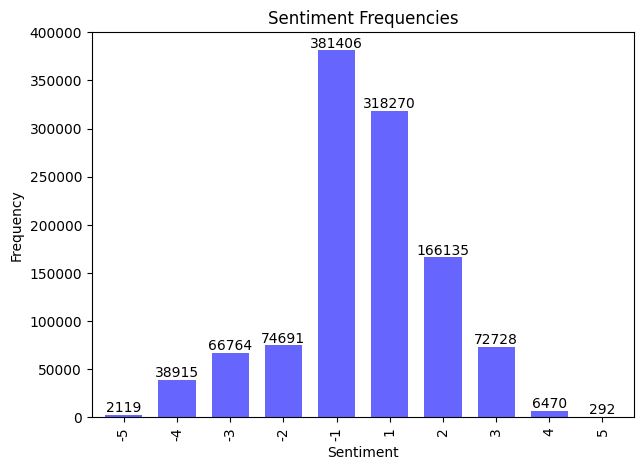

In [17]:
sentlist = sentiment_freq(data)
sentiment = [str(x[0]) for x in sentlist]
sent_freq = pd.Series([x[1] for x in sentlist])

plt.figure(figsize=(7, 5))
ax = sent_freq.plot(kind="bar", width=0.7, color='b', alpha=0.6)
ax.set_title("Sentiment Frequencies")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")
ax.set_xticklabels(sentiment)

rects = ax.patches
labels = [str(x[1]) for x in sentlist]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", \
         va="bottom"
    )
#plt.savefig("sentiment-distribution.png")
plt.show()

In [18]:
def sentiment_word_count_distribution(data):

  sentiments = data['Sentiment'].tolist()
  # split into positive and negative sentiments
  positive = []
  negative = []

  for s in sentiments:
    p, n = s.split()
    p = int(p)
    n = int(n)
    positive.append(p)
    negative.append(n)

  # select very positive, very negative and neutral sentiments
  pos_five = [x == 5 or x == 4 for x in positive]
  neg_five = [x == -5 or x == -4 for x in negative]
  neutral = [x == 1 and y == -1 for x,y in zip(positive, negative)]

  positive_tweets = list(compress(tokenized_tweets, pos_five))
  negative_tweets = list(compress(tokenized_tweets, neg_five))
  neutral_tweets = list(compress(tokenized_tweets, neutral))

  count_positive = [len(x) for x in positive_tweets]
  count_negative = [len(x) for x in negative_tweets]
  count_neutral = [len(x) for x in neutral_tweets]

  # normalize in range 1 to 0

  return [count_negative, count_neutral, count_positive]

In [19]:
counts = sentiment_word_count_distribution(data)

In [20]:
def plot_wordcount_histogram(ax, counts, title):

  d = np.diff(np.unique(counts)).min()
  left_of_first_bin = min(counts) - float(d)/2
  right_of_last_bin = max(counts) + float(d)/2
  ax.hist(counts, np.arange(left_of_first_bin, right_of_last_bin + d, d),\
          density=True, color='b', alpha=0.6)
  ax.set_title(title, fontsize=10)
  ax.set_xlabel("Word count")

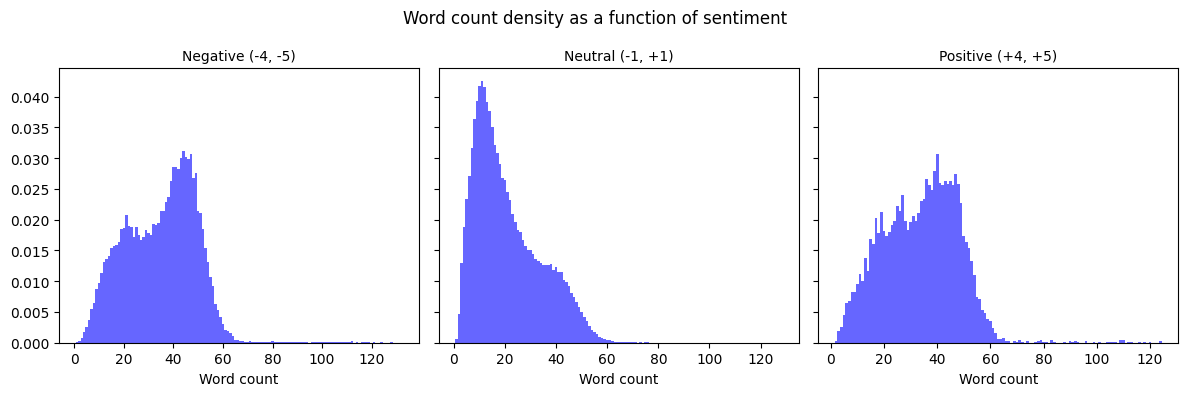

In [21]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(12,4))
titles = ["Negative (-4, -5)", "Neutral (-1, +1)", "Positive (+4, +5)"]
for axis, count, title in zip(ax, counts, titles):
  plot_wordcount_histogram(axis, count, title)
fig.suptitle("Word count density as a function of sentiment")
plt.tight_layout()
#plt.savefig("wordcount-densities.png")
plt.show()

In [47]:
# get sentiment frequencies
def sentiment_freq_sum(data):

    sentiments = data['Sentiment'].tolist()
    sum = [int(s.split()[0])+int(s.split()[1]) for s in sentiments]
    freqs = dict()
    for s in sum:
        if s in freqs:
            freqs[s] += 1
        else:
            freqs[s] = 1

    # turn dictionary into list
    sentlist = list(freqs.items())

    # order by sentiment for plot
    sentlist.sort(key=lambda x: x[0])

    return sentlist

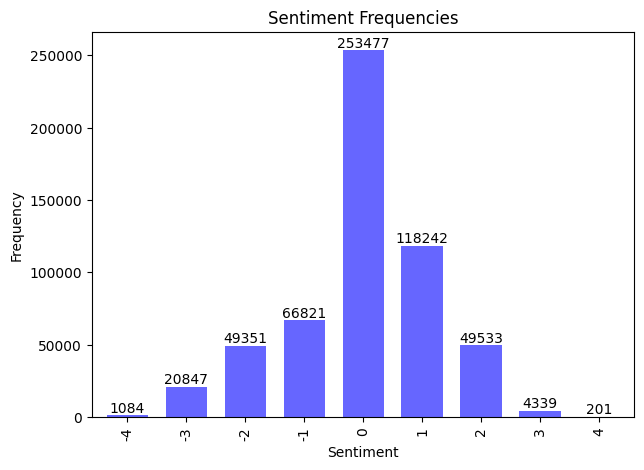

In [48]:
sentlist = sentiment_freq_sum(data)
sentiment = [str(x[0]) for x in sentlist]
sent_freq = pd.Series([x[1] for x in sentlist])

plt.figure(figsize=(7, 5))
ax = sent_freq.plot(kind="bar", width=0.7, color='b', alpha=0.6)
ax.set_title("Sentiment Frequencies")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")
ax.set_xticklabels(sentiment)

rects = ax.patches
labels = [str(x[1]) for x in sentlist]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", \
         va="bottom"
    )
#plt.savefig("sentiment-distribution.png")
plt.show()